In [1]:
import os
import SimpleITK as sitk
import glob
import monai
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    AddChanneld,
    SpatialPadd,
    RandRotate90d,
    RandShiftIntensityd,
    EnsureTyped,
    EnsureType,
    MapTransform,
    Resized,
    Invertd,
    ToTensord,
    NormalizeIntensityd,
    RandFlipd,
    Lambdad,
    Activations,
    AsDiscrete,
)
from monai.metrics import ROCAUCMetric
from monai.data import CacheDataset, ThreadDataLoader,DataLoader, Dataset, decollate_batch,load_decathlon_datalist
import torch
from monai.utils import first, set_determinism
import torch.nn as  nn
from torch.nn import Linear,  Softmax
import torch.nn.functional as F
import pandas as pd
from sklearn import metrics
torch.multiprocessing.set_sharing_strategy('file_system')

In [14]:
! scp 模型推理_Total-update.ipynb ~

In [2]:
df_raw = pd.read_csv('/app/liucd/判定_fill_df.csv')
df_cli = df_raw[['patient_ID', 'T_stage', 'HER2_status', 'NAC_classification', 'ER_percentage', 'PR_percentage', 'Ki_67']]


In [3]:

rad_features = ['patient_id', 'dce-delta-log-sigma-5-0-mm-3D_glcm_DifferenceEntropy',
 'dce-bf-log-sigma-3-0-mm-3D_firstorder_Skewness',
 'dce-bf-log-sigma-4-0-mm-3D_gldm_DependenceEntropy',
 'dce-bf-log-sigma-5-0-mm-3D_firstorder_Skewness',
 'dce-bf-wavelet-LHL_firstorder_Mean',
 'dce-bf-wavelet-LHL_glcm_DifferenceEntropy',
 'dce-bf-wavelet-LHL_glrlm_RunEntropy',
 'dce-bf-wavelet-HLL_glszm_ZoneEntropy',
 'adc-bl-wavelet-LLL_gldm_SmallDependenceEmphasis']

def merge_df(df_raw_path):
    """
    输入原始的文件路径：没有delta的
    输出 既有原有的，又有delta的列
    """
    df_raw = pd.read_csv(df_raw_path)
    print(len(df_raw))
    cols = df_raw.columns[1: -1]
    
    col_bl = [name for name in cols if '-bl-' in name]
    col_bf = [name for name in cols if '-bf-' in name]
    print(len(col_bl), len(col_bf))
    df_first = df_raw[col_bl]
    df_second = df_raw[col_bf]
    df_first.columns = [name.replace('-bl-', '-delta-') for name in df_first.columns]
    df_second.columns = [name.replace('-bf-', '-delta-') for name in df_second.columns]
    
    df_delta = df_second - df_first  # 两个dataframe相减需要相同的行名和列名
    
    df_delta.insert(loc= 0 , column= 'patient_id', value= df_raw['patient_id'])
    
    df_merge = pd.merge(df_delta, df_raw, left_on='patient_id', right_on='patient_id')  # 方法2
    df_merge = pd.concat([df_delta, df_raw[df_raw.columns[1: ]]], axis=1)  
    
    return df_merge

file_path = '/app/liucd/5center-1310-all+6status-pcr.csv'
df_rad = merge_df(file_path)
df_rad = df_rad[rad_features]

1317
2264 2263


In [4]:
pwd

'/app/liucd/deeplearn_dec/DL_multi/NewTrain2Val3/net_selfattnNew/Radiomics_test/inference'

In [5]:
syf_adcdir = '/app/liucd/deeplearn_dec/DL_dec/data_adc/syf/Mixed'
zy_adcdir = '/app/liucd/deeplearn_dec/DL_dec/data_adc/zunyi/Mixed'

sd_adcdir = '/app/liucd/deeplearn_dec/DL_dec/data_adc/shandong/Mixed'
yizhong_adcdir = '/app/liucd/deeplearn_dec/DL_dec/data_adc/yizhong/Mixed'
xian_adcdir = '/app/liucd/deeplearn_dec/DL_dec/data_adc/xian/Mixed'


syf_dcedir = '/app/liucd/deeplearn_dec/DL_dec/data/syf/Mixed'
zy_dcedir = '/app/liucd/deeplearn_dec/DL_dec/data/zunyi/Mixed'

sd_dcedir = '/app/liucd/deeplearn_dec/DL_dec/data/shandong/Mixed'
yizhong_dcedir = '/app/liucd/deeplearn_dec/DL_dec/data/yizhong/Mixed'
xian_dcedir = '/app/liucd/deeplearn_dec/DL_dec/data/xian/Mixed'


train_adcimages = sorted(glob.glob(os.path.join(syf_adcdir,  '*.nii.gz'))) + \
                 sorted(glob.glob(os.path.join(zy_adcdir,  '*.nii.gz')))


train_dceimages = sorted(glob.glob(os.path.join(syf_dcedir,  '*.nii.gz'))) + \
                 sorted(glob.glob(os.path.join(zy_dcedir,  '*.nii.gz')))



val_adcimages =  sorted(glob.glob(os.path.join(sd_adcdir,  '*.nii.gz'))) + \
                 sorted(glob.glob(os.path.join(yizhong_adcdir,  '*.nii.gz'))) + \
                 sorted(glob.glob(os.path.join(xian_adcdir,  '*.nii.gz'))) 

val_dceimages =  sorted(glob.glob(os.path.join(sd_dcedir,  '*.nii.gz'))) + \
                 sorted(glob.glob(os.path.join(yizhong_dcedir,  '*.nii.gz'))) + \
                 sorted(glob.glob(os.path.join(xian_dcedir,  '*.nii.gz'))) 


val_clinical = []
for file_path in val_adcimages:
    p_id = file_path.split('_')[-4]
    clinical_data = df_cli[df_cli['patient_ID'] == int(p_id)].values.tolist()[0][1:]
    val_clinical.append(clinical_data)

val_rad = []
for file_path in val_adcimages:
    p_id = file_path.split('_')[-4]
    rad_data = df_rad[df_rad['patient_id'] == int(p_id)].values.tolist()[0][1:]
    val_rad.append(rad_data)

val_dict = [{'image_adc': image_adc, 'image_dce': image_dce, 'rad': rad,  'clinical': clinical,  'label': int(image_adc.split('_')[-1].replace('.nii.gz', ''))}
                  for image_adc, image_dce, rad, clinical in zip(val_adcimages, val_dceimages, val_rad, val_clinical)]



train_clinical = []
for file_path in train_adcimages:
    p_id = file_path.split('_')[-4]
    clinical_data = df_cli[df_cli['patient_ID'] == int(p_id)].values.tolist()[0][1:]
    train_clinical.append(clinical_data)

train_rad = []
for file_path in train_adcimages:
    p_id = file_path.split('_')[-4]
    rad_data = df_rad[df_rad['patient_id'] == int(p_id)].values.tolist()[0][1:]
    train_rad.append(rad_data)
    

train_dict = [{'image_adc': image_adc, 'image_dce': image_dce, 'rad': rad,  'clinical': clinical,  'label': int(image_adc.split('_')[-1].replace('.nii.gz', ''))}
                  for image_adc, image_dce, rad, clinical in zip(train_adcimages,  train_dceimages, train_rad, train_clinical)]

print(val_dict[-1])
print(len(val_dict))
print(train_dict[-1])
print(len(train_dict))

{'image_adc': '/app/liucd/deeplearn_dec/DL_dec/data_adc/xian/Mixed/236_1412879_ADC2_0000_0.nii.gz', 'image_dce': '/app/liucd/deeplearn_dec/DL_dec/data/xian/Mixed/236_1412879_+C2_0000_0.nii.gz', 'rad': [1.2473272629999999, 0.513161509, 7.360802124, 0.79456651, -3.795516269, 3.605445809, 4.823300507, 6.446684546, 0.791294387], 'clinical': [1.0, 0.0, 2.0, 0.0, 0.0, 0.7], 'label': 0}
618
{'image_adc': '/app/liucd/deeplearn_dec/DL_dec/data_adc/zunyi/Mixed/2022_10_20_1650366_ADC2_0000_0.nii.gz', 'image_dce': '/app/liucd/deeplearn_dec/DL_dec/data/zunyi/Mixed/2022_10_20_1650366_+C2_0000_0.nii.gz', 'rad': [-0.426334239, 0.315025113, 8.35283075, 0.068442358, 0.121029744, 2.725956892, 4.15475501, 7.113295602, 0.737770167], 'clinical': [3.0, 1.0, 2.0, 0.0, 0.0, 0.2], 'label': 0}
691


In [6]:
for idx, each_data in enumerate(train_dict):

    adc_id = each_data['image_adc'].split('_')[-4]
    dce_id = each_data['image_dce'].split('_')[-4]
    assert adc_id == dce_id

In [7]:

sd_adcimages =  sorted(glob.glob(os.path.join(sd_adcdir,  '*.nii.gz'))) 
yizhong_adcimages = sorted(glob.glob(os.path.join(yizhong_adcdir,  '*.nii.gz'))) 
xian_adcimages = sorted(glob.glob(os.path.join(xian_adcdir,  '*.nii.gz'))) 

sd_dceimages =  sorted(glob.glob(os.path.join(sd_dcedir,  '*.nii.gz'))) 
yizhong_dceimages =  sorted(glob.glob(os.path.join(yizhong_dcedir,  '*.nii.gz')))
xian_dceimages =  sorted(glob.glob(os.path.join(xian_dcedir,  '*.nii.gz'))) 


sd_clinical = []
yizhong_clinical = []
xian_clinical = []
for file_path in sd_adcimages:
    p_id = file_path.split('_')[-4]
    clinical_data = df_cli[df_cli['patient_ID'] == int(p_id)].values.tolist()[0][1:]
    sd_clinical.append(clinical_data)

for file_path in yizhong_adcimages:
    p_id = file_path.split('_')[-4]
    clinical_data = df_cli[df_cli['patient_ID'] == int(p_id)].values.tolist()[0][1:]
    yizhong_clinical.append(clinical_data)

for file_path in xian_adcimages:
    p_id = file_path.split('_')[-4]
    clinical_data = df_cli[df_cli['patient_ID'] == int(p_id)].values.tolist()[0][1:]
    xian_clinical.append(clinical_data)



sd_rad = []
yizhong_rad = []
xian_rad = []

for file_path in sd_adcimages:
    p_id = file_path.split('_')[-4]
    rad_data = df_rad[df_rad['patient_id'] == int(p_id)].values.tolist()[0][1:]
    sd_rad.append(rad_data)

for file_path in yizhong_adcimages:
    p_id = file_path.split('_')[-4]
    rad_data = df_rad[df_rad['patient_id'] == int(p_id)].values.tolist()[0][1:]
    yizhong_rad.append(rad_data)

for file_path in xian_adcimages:
    p_id = file_path.split('_')[-4]
    rad_data = df_rad[df_rad['patient_id'] == int(p_id)].values.tolist()[0][1:]
    xian_rad.append(rad_data)


sd_dict = [{'image_adc': image_adc, 'image_dce': image_dce, 'rad': rad,  'clinical': clinical,  'label': int(image_adc.split('_')[-1].replace('.nii.gz', ''))}
                  for image_adc, image_dce, rad, clinical in zip(sd_adcimages, sd_dceimages, sd_rad, sd_clinical)]

yizhong_dict = [{'image_adc': image_adc, 'image_dce': image_dce, 'rad': rad,  'clinical': clinical,  'label': int(image_adc.split('_')[-1].replace('.nii.gz', ''))}
                  for image_adc, image_dce, rad, clinical in zip(yizhong_adcimages, yizhong_dceimages, yizhong_rad,  yizhong_clinical)]

xian_dict = [{'image_adc': image_adc, 'image_dce': image_dce, 'rad': rad,  'clinical': clinical,  'label': int(image_adc.split('_')[-1].replace('.nii.gz', ''))}
                  for image_adc, image_dce, rad, clinical in zip(xian_adcimages, xian_dceimages, xian_rad, xian_clinical)]

print(sd_dict[-1])
print(yizhong_dict[-1])
print(xian_dict[-1])
len(sd_dict), len(yizhong_dict), len(xian_dict)

{'image_adc': '/app/liucd/deeplearn_dec/DL_dec/data_adc/shandong/Mixed/516_xu_feng_hua_637730_ADC2_0000_0.nii.gz', 'image_dce': '/app/liucd/deeplearn_dec/DL_dec/data/shandong/Mixed/516_xu_feng_hua_637730_+C2_0000_0.nii.gz', 'rad': [-0.41953666200000006, -0.382612157, 7.047616843, -0.364690779, -4.494328189, 1.325575211, 4.154024684, 6.490821069, 0.650189256], 'clinical': [3.0, 1.0, 2.0, 0.9, 0.9, 0.3], 'label': 0}
{'image_adc': '/app/liucd/deeplearn_dec/DL_dec/data_adc/yizhong/Mixed/205_1510029_ADC2_0000_0.nii.gz', 'image_dce': '/app/liucd/deeplearn_dec/DL_dec/data/yizhong/Mixed/205_1510029_+C2_0000_0.nii.gz', 'rad': [-2.156213692, 0.443251135, 6.043469151, 0.529713073, -0.01033215, 0.982131171, 3.543917477, 4.058962719, 0.079513089], 'clinical': [2.0, 0.0, 2.0, 0.8, 0.2, 0.5], 'label': 0}
{'image_adc': '/app/liucd/deeplearn_dec/DL_dec/data_adc/xian/Mixed/236_1412879_ADC2_0000_0.nii.gz', 'image_dce': '/app/liucd/deeplearn_dec/DL_dec/data/xian/Mixed/236_1412879_+C2_0000_0.nii.gz', 'rad'

(236, 200, 182)

In [8]:
val_transforms = Compose(
        [
            LoadImaged(keys=["image_adc",'image_dce' ]),
            EnsureChannelFirstd(keys=["image_adc", 'image_dce']),
            Orientationd(keys=["image_adc",'image_dce'], axcodes="RAS"),
            Resized(keys=["image_adc"], spatial_size=(64, 64, 16)),
            Resized(keys=["image_dce"], spatial_size=(96, 96, 32)),
            
            NormalizeIntensityd(keys=["image_adc", 'image_dce'], nonzero=True, channel_wise=True),
            ToTensord(keys=['image_adc', 'image_dce', 'rad', 'clinical', 'label'])
        ]
    )


val_ds = Dataset(data=val_dict, transform=val_transforms)
train_ds = Dataset(data=train_dict, transform=val_transforms)
sd_ds = Dataset(data=sd_dict, transform=val_transforms)
yizhong_ds = Dataset(data=yizhong_dict, transform=val_transforms)
xian_ds = Dataset(data=xian_dict, transform=val_transforms)

# create a validation data loader
val_loader = DataLoader(val_ds, batch_size=1, num_workers=16, pin_memory=True)
train_loader = DataLoader(train_ds, batch_size=1, num_workers=16, pin_memory=True)
sd_loader = DataLoader(sd_ds, batch_size=1, num_workers=16, pin_memory=True)
yizhong_loader = DataLoader(yizhong_ds, batch_size=1, num_workers=16, pin_memory=True)
xian_loader = DataLoader(xian_ds, batch_size=1, num_workers=16, pin_memory=True)

In [9]:

class DoubleTower(nn.Module):
    def __init__(self,
                 pretrained_dce='',
                 pretrained_adc='',
                 device = torch.device("cuda"),
                 num_classes=2,
                 fc_hidden_size = 256
                ):
        super().__init__()
        self.pretrained_dce = pretrained_dce
        self.pretrained_adc = pretrained_adc
        self.fc_hidden_size = fc_hidden_size
        self.num_classes = num_classes
        self.device = device

        self.model_dce = monai.networks.nets.resnet34(spatial_dims=3, n_input_channels=1, num_classes=2, feed_forward=False).to(self.device)
        self.model_adc = monai.networks.nets.resnet34(spatial_dims=3, n_input_channels=1, num_classes=2, feed_forward=False).to(self.device)

        if  pretrained_dce != '':
            dce_dict = self.model_dce.state_dict()
            dce_pretrain = torch.load(self.pretrained_dce, map_location=self.device)
            dce_pretrain_dict = {k:v for k, v in dce_pretrain.items() if  k in  dce_dict.keys()}
            dce_dict.update(dce_pretrain_dict)
            self.model_dce.load_state_dict(dce_dict)

        if  pretrained_adc !='':
            adc_dict = self.model_adc.state_dict()
            adc_pretrain = torch.load(self.pretrained_adc, map_location=self.device)
            adc_pretrain_dict = {k:v for k, v in adc_pretrain.items() if  k in  adc_dict.keys()}
            adc_dict.update(adc_pretrain_dict)
            self.model_adc.load_state_dict(adc_dict)

        self.attn = nn.MultiheadAttention(512, num_heads=8, batch_first=True, device=self.device)

        # self.Linear1 = Linear(1024 + 6, self.num_classes, device=self.device)
        self.Linear1 = Linear(512, self.fc_hidden_size, device=self.device)  # 1024 是 所有下采样特征图globalpool之后拼接的结果
        self.Linear2 = Linear(self.fc_hidden_size + 6 + 9, self.num_classes, device=self.device)
        self.dropout = nn.Dropout(0.2)


    def forward(self, x1, x2, rad,  structured_data):  # x 是SegResNet的输入影像矩阵

        encode_output1 = self.model_dce(x1)
        encode_output2 = self.model_dce(x2)

        concatenated = encode_output1 * encode_output2
        
        concatenated = concatenated.unsqueeze(1)
        attn_output, _ = self.attn(concatenated, concatenated, concatenated)

        attn_output = attn_output.squeeze(1)

        fc1 = F.relu(self.Linear1(attn_output))
        # fc1 = self.dropout(fc1)

        fc2 = self.Linear2( torch.concat([fc1, rad, structured_data], dim=-1))
   
        return F.log_softmax(fc2, dim=-1)


In [10]:

# dce_pretrain_path = ''   
# adc_pretrain_path = ''

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = DoubleTower(device = device)

model_path = '/app/liucd/deeplearn_dec/DL_multi/NewTrain2Val3/net_selfattnNew/Radiomics_test/FreezeWeight/model_0.81_0.867.pth'
model.load_state_dict(torch.load(model_path, map_location=device))


<All keys matched successfully>

In [11]:
def report_metric(label_list, pred_list):
    Cmatrix = metrics.confusion_matrix(label_list, pred_list)
    TN = Cmatrix[0, 0]
    TP = Cmatrix[1, 1]
    FN = Cmatrix[1, 0]
    FP = Cmatrix[0, 1]
    print(Cmatrix)
    Acc = (TP+TN) / (TP+TN+FP+FN)
    sensitivity = TPR = Recall = TP / (TP+FN)
    specificity = TNR =  TN / (FP+TN)
    PPV = TP / (TP + FP)
    NPV = TN / (TN + FN)
    
    return Acc, sensitivity, specificity, PPV, NPV

In [13]:
post_pred = Compose([Activations(softmax=True)])
post_label = Compose([AsDiscrete(to_onehot=2)])

auc_metric = ROCAUCMetric()

prob_list = []
label_list = []

model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)

    for val_data in train_loader:

        val_dce, val_adc, val_rad, val_clinical, val_labels = val_data["image_dce"].to(device),val_data["image_adc"].to(device), val_data["rad"].to(device), val_data["clinical"].to(device), val_data["label"].to(device)
        val_output = model(val_dce, val_adc, val_rad, val_clinical)
         
        prob_list.append(post_pred(val_output[0])[1].item())  # [0] 是由于设置batch=1 [1] 是是取预测类别中的1类别
        label_list.append(val_labels.item())
        
        # monai
        y_pred = torch.cat([y_pred, val_output], dim=0)
        y = torch.cat([y, val_labels], dim=0)
        
        y_onehot = [post_label(i) for i in decollate_batch(y, detach=False)]
        y_pred_act = [post_pred(i) for i in decollate_batch(y_pred)]

# sklearn
pred_list = [round(i) for i in prob_list]
Acc, sensitivity, specificity, PPV, NPV = report_metric(label_list, pred_list)
print('Accuray:', Acc)
print('SEN/SPE:', sensitivity, specificity)
print('PPV/NPV: ', PPV, NPV)

fpr, tpr, thresholds = metrics.roc_curve(label_list, prob_list, pos_label=1)
print(metrics.auc(fpr, tpr))

# # monai
auc_metric(y_pred_act, y_onehot)
print(auc_metric.aggregate())

acc_value = torch.eq(y_pred.argmax(dim=1), y)
acc_metric = acc_value.sum().item() / len(acc_value)
print(acc_metric)

[[399  50]
 [ 92 150]]
Accuray: 0.7945007235890015
SEN/SPE: 0.6198347107438017 0.888641425389755
PPV/NPV:  0.75 0.8126272912423625
0.8714682766110181
0.8714682766110181
0.7945007235890015


In [69]:
[[379  46]
 [ 71 122]]
Accuray: 0.8106796116504854
SEN/SPE: 0.6321243523316062 0.8917647058823529
PPV/NPV:  0.7261904761904762 0.8422222222222222
0.8672599817128924
0.8672599817128924
0.8106796116504854

array([[0.60351413, 0.06417112],
       [0.12605042, 0.20626432]])

In [79]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("显示百分比：")
        np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
        print(cm)
    else:
        print('显示具体数字：')
        print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    # matplotlib版本问题，如果不加下面这行代码，则绘制的混淆矩阵上下只能显示一半，有的版本的matplotlib不需要下面的代码，分别试一下即可
    plt.ylim(len(classes) - 0.5, -0.5)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    

显示百分比：
[[ 0.90  0.10]
 [ 0.38  0.62]]


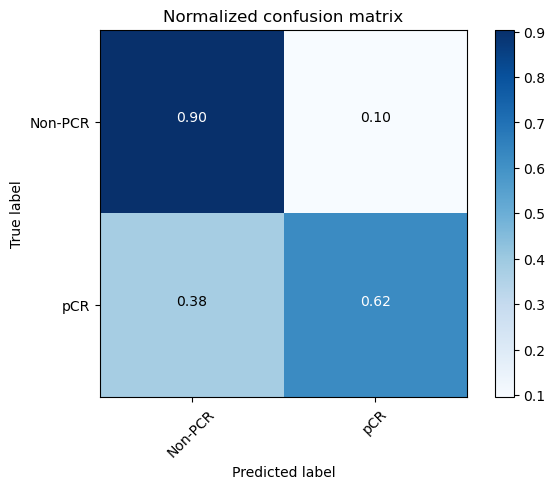

<module 'matplotlib.pyplot' from '/app/data/anaconda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

In [78]:
cnf_matrix = a + b
attack_types = ['Non-PCR', 'pCR',]
plot_confusion_matrix(cnf_matrix, classes=attack_types, normalize=True, title='Normalized confusion matrix')
plt

In [ ]:
Acc, sensitivity, specificity, PPV, NPV
val： 
Accuray: 0.7977346278317152
SEN/SPE: 0.5906735751295337 0.8917647058823529
PPV/NPV:  0.7125 0.8275109170305677
0.852386467540384
0.42999999999999994
0.8090614886731392 0.7098445595854922 0.8541176470588235 0.6884422110552764 0.8663484486873508

Train:
Accuray: 0.8205499276410999
SEN/SPE: 0.6446280991735537 0.9153674832962138
PPV/NPV:  0.8041237113402062 0.8269617706237424
0.8994091553314068
0.42999999999999994
0.8364688856729378 0.731404958677686 0.8930957683741648 0.7866666666666666 0.8605150214592274

xian:
Accuray: 0.7802197802197802
SEN/SPE: 0.6666666666666666 0.8712871287128713
PPV/NPV:  0.8059701492537313 0.7652173913043478
0.8450067228945117
0.48
0.7857142857142857 0.691358024691358 0.8613861386138614 0.8 0.7767857142857143

yizhong
Accuray: 0.82
SEN/SPE: 0.4583333333333333 0.8693181818181818
PPV/NPV:  0.3235294117647059 0.9216867469879518
0.8328598484848484
0.6
0.84 0.375 0.9034090909090909 0.34615384615384615 0.9137931034482759

shandong
Accuray: 0.7923728813559322
SEN/SPE: 0.5568181818181818 0.9324324324324325
PPV/NPV:  0.8305084745762712 0.7796610169491526
0.8665540540540541
0.42999999999999994
0.8305084745762712 0.7386363636363636 0.8851351351351351 0.7926829268292683 0.8506493506493507

0.42999999999999994
0.8090614886731392 0.7098445595854922 0.8541176470588235 0.6884422110552764 0.8663484486873508


Text(0, 0.5, 'Accuracy')

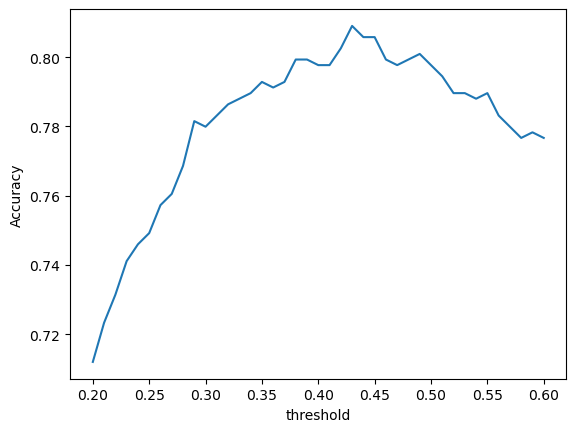

In [57]:
import matplotlib.pyplot as plt
import numpy as np

def fun(x, threshold):
    if x > threshold:
        return 1
    else:
        return 0

Acc_list = []
th_list = np.linspace(0.2, 0.6, 41).tolist()
for th in th_list:
    
    pred_list = [fun(i, th) for i in prob_list]
    Acc, sensitivity, specificity, PPV, NPV = report_metric(label_list, pred_list)
    Acc_list.append(Acc)
use_th = th_list[Acc_list.index(max(Acc_list))]
print(use_th)
pred_list = [fun(i, use_th) for i in prob_list]
Acc, sensitivity, specificity, PPV, NPV = report_metric(label_list, pred_list)
print(Acc, sensitivity, specificity, PPV, NPV)
plt.plot(th_list, Acc_list)
plt.xlabel('threshold')
plt.ylabel('Accuracy')

In [140]:
import matplotlib.pyplot as plt
import numpy as np

def fun(x, threshold):
    if x > threshold:
        return 1
    else:
        return 0

pred_list = [fun(i, 0.45) for i in prob_list]
Acc, sensitivity, specificity, PPV, NPV = report_metric(label_list, pred_list)
print(Acc, sensitivity, specificity, PPV, NPV)


0.7800289435600579 0.5289256198347108 0.9153674832962138 0.7710843373493976 0.7828571428571428


In [113]:
# center  th0.5 (th0.34)  AUC
#sd      0.73(0.844)     0.8663819402074435
#yizhong 0.88(0.84)      0.84 
# xian   0.71(0.76)      0.85
# train 0.75 (0.786)     0.85
(0.84+0.84+0.76+0.786) / 4

0.8065

In [131]:
# center  th0.5   AUC
#sd       0.776  0.86
#yizhong  0.86   0.87
# xian    0.75   0.82
# train   0.778  0.85   
(0.776+0.86+0.75+0.778) / 4

0.791

In [151]:
error_val = []

for val_data in val_loader:

        val_dce, val_adc, val_clinical, val_labels = val_data["image_dce"].to(device),val_data["image_adc"].to(device), val_data["clinical"].to(device), val_data["label"].to(device)
        val_output = model(val_dce, val_adc, val_clinical)
         
        pred_prob = round(post_pred(val_output[0])[1].item())
        label = val_labels.item()
        if pred_prob != label:
            error_val.append(val_data['image_dce_meta_dict']['filename_or_obj'][0])
        
     

In [152]:
len(error_val)

140

In [81]:
len(label_list)

691

In [80]:
len(pred_list)

691

In [94]:
pred_0 = [prob_list[i] for i in range(len(label_list)) if label_list[i] == 0]
pred_1 = [prob_list[i] for i in range(len(label_list)) if label_list[i] == 1]
len(pred_0), len(pred_1)

(449, 242)

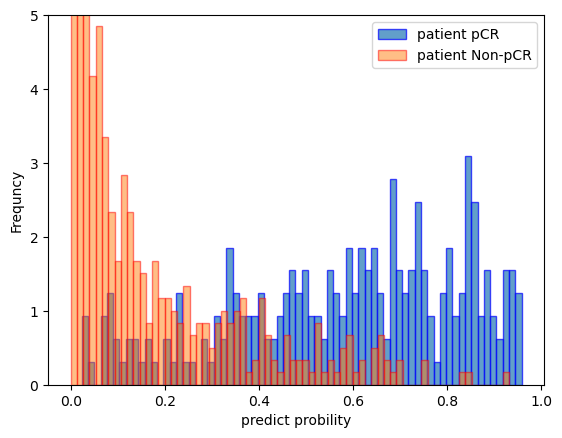

In [148]:
from scipy import stats

count_1 = plt.hist(pred_1, bins=70, density=True, alpha=0.7, edgecolor='blue')
count_0  = plt.hist(pred_0, bins=70, density=True, alpha=0.5, edgecolor='red')
plt.ylim(0, 5)
plt.xlabel('predict probility')
plt.ylabel('Frequncy')
plt.legend(['patient pCR', 'patient Non-pCR'])

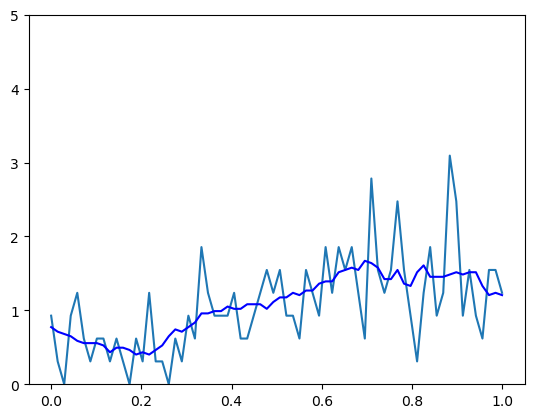

In [155]:
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import make_interp_spline
plt.plot(np.linspace(0, 1, len(count_1[0])), count_1[0])
# plt.plot(count_0[0])
plt.ylim(0, 5)

# 使用Savitzky-Golay 滤波器后得到平滑图线
from scipy.signal import savgol_filter
y = savgol_filter(count_1[0], 10, 1, mode= 'nearest')
plt.plot(np.linspace(0, 1, len(count_1[0])), y, 'b',)

In [166]:
len(prob_list)

200

In [169]:
df_data = pd.DataFrame({'pred': prob_list, 'label': label_list})
df_data.to_csv('xian.csv')